In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

%matplotlib inline
pd.set_option("display.max_columns", 120)


In [14]:
valid_truth = df["antibody_truth"].isin(["Positive", "Negative"])
valid_test = df["pan_result"].isin(["Positive", "Negative"])
data = df[valid_truth & valid_test].copy()

print("Rows with valid truth & pan_result:", data.shape[0])

data["days_from_symptom_num"] = pd.to_numeric(
    data["days_from_symptom"], errors="coerce"
)
for col in ["pan_titer", "igg_titer", "igm_titer"]:
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)

truth_pos = data[data["antibody_truth"] == "Positive"].copy()
truth_pos["detected"] = (truth_pos["pan_result"] == "Positive").astype(int)
print("Truth-positive samples:", truth_pos.shape[0])

median_days = truth_pos["days_from_symptom_num"].median()
print("Median days_from_symptom_num:", median_days)
truth_pos["days_from_symptom_num"] = truth_pos["days_from_symptom_num"].fillna(median_days)

truth_pos["type"] = truth_pos["type"].astype(str).replace({"nan": "Unknown"})
truth_pos["manufacturer"] = truth_pos["manufacturer"].astype(str)

truth_pos[["manufacturer","pan_titer","igg_titer","igm_titer",
           "days_from_symptom_num","type","detected"]].head()


Rows with valid truth & pan_result: 1424
Truth-positive samples: 385
Median days_from_symptom_num: 26.0


,manufacturer,pan_titer,igg_titer,igm_titer,days_from_symptom_num,type,detected
51,"Plexense, Inc.",1600,1600,400,35.0,Serum,1
162,MedMira Inc.,6400,6400,1600,42.0,Serum,1
163,MedMira Inc.,6400,6400,6400,20.0,Serum,1
168,MedMira Inc.,400,400,100,24.0,Serum,0
175,MedMira Inc.,1600,6400,400,42.0,Serum,0


In [15]:
def sensitivity_for_group(g):
    tp = (g["pan_result"] == "Positive").sum()
    fn = (g["pan_result"] == "Negative").sum()
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    return pd.Series({"N": len(g), "TP": tp, "FN": fn, "Sensitivity": sens})

raw_manu_sens = (
    truth_pos
    .groupby("manufacturer")
    .apply(sensitivity_for_group)
    .reset_index()
    .sort_values("Sensitivity")
)

raw_manu_sens.head(10)


C:\Users\rbodh\AppData\Local\Temp\ipykernel_11908\2427846361.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sensitivity_for_group)


,manufacturer,N,TP,FN,Sensitivity
5,MedMira Inc.,30.0,16.0,14.0,0.533333
7,"Plexense, Inc.",30.0,22.0,8.0,0.733333
1,Bio-Rad,58.0,54.0,4.0,0.931034
6,"NOWDiagnostics, Inc.",30.0,28.0,2.0,0.933333
2,Fisher Diagnostics,30.0,29.0,1.0,0.966667
9,Roche Diagnostic Corporation,30.0,29.0,1.0,0.966667
3,LumiraDX UK Ltd,30.0,30.0,0.0,1.000000
0,Beijing Wantai Biological Pharmacy Enterprise ...,59.0,59.0,0.0,1.000000
4,LumiraDx UK Ltd,30.0,30.0,0.0,1.000000
8,QIAGEN GmbH,30.0,30.0,0.0,1.000000


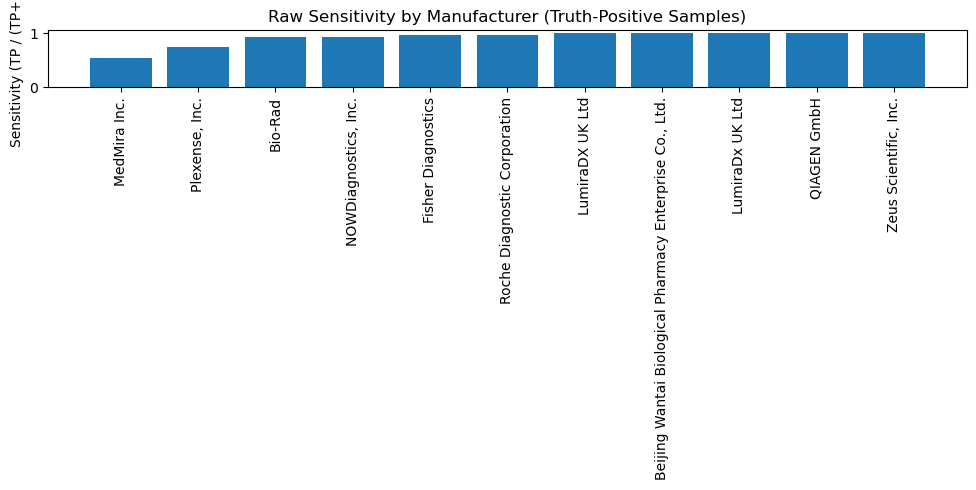

In [6]:
plt.figure(figsize=(10, 5))
x = np.arange(len(raw_manu_sens))
plt.bar(x, raw_manu_sens["Sensitivity"])
plt.xticks(x, raw_manu_sens["manufacturer"], rotation=90)
plt.ylabel("Sensitivity (TP / (TP+FN))")
plt.ylim(0, 1.05)
plt.title("Raw Sensitivity by Manufacturer (Truth-Positive Samples)")
plt.tight_layout()
plt.show()


In [7]:
features_A = ["pan_titer", "igg_titer", "igm_titer", "days_from_symptom_num", "type"]
X_A = truth_pos[features_A]
y = truth_pos["detected"]

numeric_features_A = ["pan_titer", "igg_titer", "igm_titer", "days_from_symptom_num"]
categorical_features_A = ["type"]

numeric_transformer_A = StandardScaler()
categorical_transformer_A = OneHotEncoder(handle_unknown="ignore")

preprocess_A = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_A, numeric_features_A),
        ("cat", categorical_transformer_A, categorical_features_A),
    ]
)

clf_A = LogisticRegression(max_iter=2000)

pipe_A = Pipeline(steps=[("preprocess", preprocess_A), ("clf", clf_A)])

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(
    X_A, y, test_size=0.3, random_state=42, stratify=y
)

pipe_A.fit(X_A_train, y_A_train)

y_A_prob = pipe_A.predict_proba(X_A_test)[:, 1]
y_A_pred = pipe_A.predict(X_A_test)

print("=== Model A – Biology & Sample Only ===")
print(classification_report(y_A_test, y_A_pred))

fpr_A, tpr_A, _ = roc_curve(y_A_test, y_A_prob)
auc_A = auc(fpr_A, tpr_A)
print("ROC AUC (Model A):", auc_A)


=== Model A – Biology & Sample Only ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.92      1.00      0.96       107

    accuracy                           0.92       116
   macro avg       0.46      0.50      0.48       116
weighted avg       0.85      0.92      0.89       116

ROC AUC (Model A): 0.8011422637590861


C:\Users\rbodh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rbodh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rbodh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


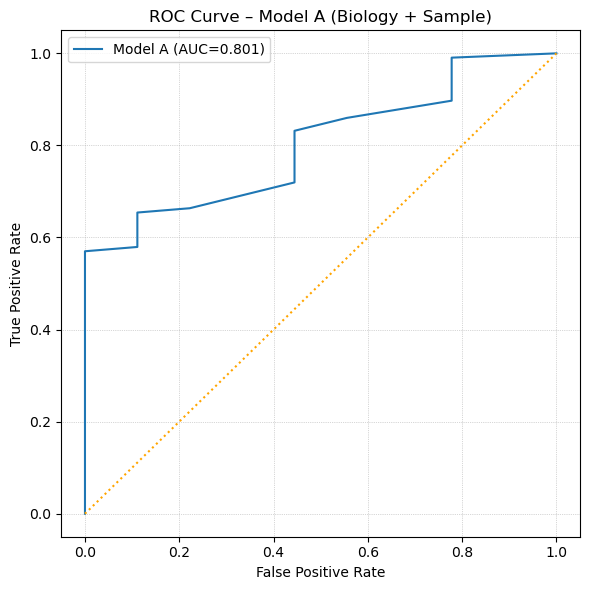

In [8]:
plt.figure(figsize=(6, 6))
plt.plot(fpr_A, tpr_A, label=f"Model A (AUC={auc_A:.3f})")
plt.plot([0, 1], [0, 1], linestyle=":", color="orange")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model A (Biology + Sample)")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


In [9]:
features_B = ["pan_titer", "igg_titer", "igm_titer",
              "days_from_symptom_num", "type", "manufacturer"]
X_B = truth_pos[features_B]

numeric_features_B = ["pan_titer", "igg_titer", "igm_titer", "days_from_symptom_num"]
categorical_features_B = ["type", "manufacturer"]

numeric_transformer_B = StandardScaler()
categorical_transformer_B = OneHotEncoder(handle_unknown="ignore")

preprocess_B = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_B, numeric_features_B),
        ("cat", categorical_transformer_B, categorical_features_B),
    ]
)

clf_B = LogisticRegression(max_iter=2000)

pipe_B = Pipeline(steps=[("preprocess", preprocess_B), ("clf", clf_B)])

X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(
    X_B, y, test_size=0.3, random_state=42, stratify=y
)

pipe_B.fit(X_B_train, y_B_train)

y_B_prob = pipe_B.predict_proba(X_B_test)[:, 1]
y_B_pred = pipe_B.predict(X_B_test)

print("=== Model B – Biology + Sample + Manufacturer ===")
print(classification_report(y_B_test, y_B_pred))

fpr_B, tpr_B, _ = roc_curve(y_B_test, y_B_prob)
auc_B = auc(fpr_B, tpr_B)
print("ROC AUC (Model B):", auc_B)


=== Model B – Biology + Sample + Manufacturer ===
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.94      0.99      0.96       107

    accuracy                           0.93       116
   macro avg       0.80      0.61      0.65       116
weighted avg       0.92      0.93      0.91       116

ROC AUC (Model B): 0.9771547248182763


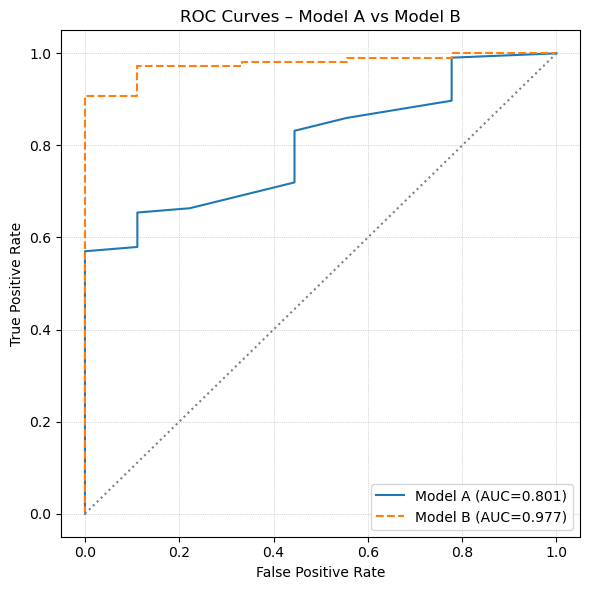

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(fpr_A, tpr_A, label=f"Model A (AUC={auc_A:.3f})")
plt.plot(fpr_B, tpr_B, label=f"Model B (AUC={auc_B:.3f})", linestyle="--")
plt.plot([0, 1], [0, 1], linestyle=":", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model A vs Model B")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


## 5. Coefficient Inspection – Biological vs Manufacturer Effects


In [11]:
# Extract feature names after preprocessing
ohe = pipe_B.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features_B)
all_feature_names = list(ohe_feature_names) + numeric_features_B

coef_B = pd.DataFrame({
    "feature": all_feature_names,
    "coef": pipe_B.named_steps["clf"].coef_[0]
}).sort_values("coef", ascending=False)

coef_B.head(20)


,feature,coef
5,manufacturer_LumiraDx UK Ltd,0.966856
1,manufacturer_Beijing Wantai Biological Pharmac...,0.950106
2,manufacturer_Bio-Rad,0.902893
0,type_Serum,0.800261
8,"manufacturer_Plexense, Inc.",0.780575
9,manufacturer_QIAGEN GmbH,0.766682
13,igg_titer,0.705414
15,days_from_symptom_num,0.630876
14,igm_titer,0.230683
7,"manufacturer_NOWDiagnostics, Inc.",0.074336


C:\Users\rbodh\AppData\Local\Temp\ipykernel_11908\1708897568.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


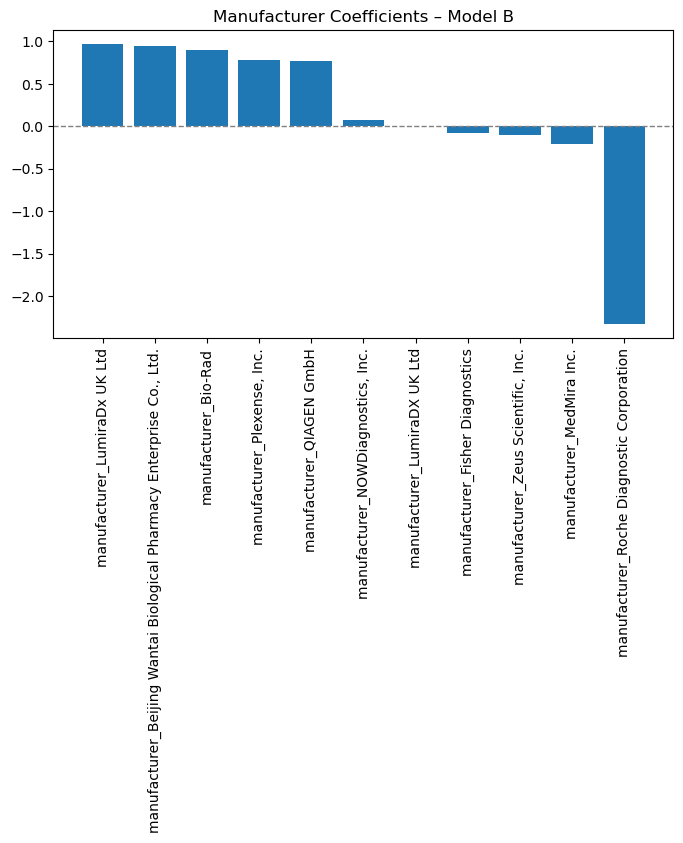

In [13]:
plt.figure(figsize=(8, 4))
plt.bar(manu_coef["feature"], manu_coef["coef"])
plt.xticks(rotation=90)
plt.axhline(0, linestyle="--", linewidth=1, color="gray")
plt.title("Manufacturer Coefficients – Model B")
plt.tight_layout()
plt.show()
